In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Load data

## Load housing data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_housing():
housing_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/housing.data', header=None, delim_whitespace=True)
housing_df.columns = [
    'crim', # numerical
    'zn', # numerical
    'nonretail', # numerical
    'river', # binary
    'nox', # numerical
    'rooms', # numerical
    'age', # numerical
    'dis', # numerical
    'rad', # numerical
    'tax', # numerical
    'ptratio', # numerical
    'b', # numerical
    'lstat', # numerical
    'medv', # numerical -- this is the target
  ]

if housing_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {housing_df.isna().sum().max()} NAs' )

HOUSING_NUMERICAL_COLS = [
  'crim', # numerical
  'zn', # numerical
  'nonretail', # numerical
  'nox', # numerical
  'rooms', # numerical
  'age', # numerical
  'dis', # numerical
  'rad', # numerical
  'tax', # numerical
  'ptratio', # numerical
  'b', # numerical
  'lstat', # numerical
]

#NO_TRANSFORM = ['river']

housing_df.head()

Mounted at /content/gdrive/
There is no NA values


,crim,zn,nonretail,river,nox,rooms,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
def get_housing_data(test_size=0.3):
  class HousingDataTransformer:
    def __init__(self, numerical_columns):
      self.numerical_columns = numerical_columns

    def fit(self, X):
      self.transformers = []
      self.features_dim = X.shape[1]
      for c in range(self.features_dim):
        if (X.columns[c] in self.numerical_columns):
          scaler = StandardScaler()
          scaler.fit(X.iloc[:,c].values.reshape(-1, 1))
          self.transformers.append(scaler)
        else:
          self.transformers.append(None)
    
    def transform(self, X):
      result = np.zeros((len(X), self.features_dim))
      i = 0
      for c in range(self.features_dim):
        scaler = self.transformers[c]
        if (X.columns[c] in self.numerical_columns):
          result[:,i] = scaler.transform(X.iloc[:,c].values.reshape(-1, 1)).flatten()
        else:
          result[:,i] = X.iloc[:,c]
        i += 1
      return result

    def fit_transform(self, X):
      self.fit(X)
      return self.transform(X)
    
  df = housing_df.copy()
  X = df.iloc[:,:-1]
  Y = df['medv']
  N = len(X)
  transformer = HousingDataTransformer(HOUSING_NUMERICAL_COLS)

  if test_size > 0.0:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
  else:
    X_train, X_test, Y_train, Y_test = X, None, Y, None

  X_train_transformed = transformer.fit_transform(X_train)
  if X_test is not None:
    return X_train_transformed, transformer.transform(X_test), Y_train.values, Y_test.values
  else:
    return X_train_transformed, None, Y_train.values, None

## Load mushroom data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

mushroom_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/agaricus-lepiota.data', header=None)

if mushroom_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mushroom_df.isna().sum().max()} NAs' )

MUSHROOM_NUMERICAL_COLS = ()
MUSHROOM_CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

mushroom_df.head()

Mounted at /content/gdrive/
There is no NA values


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [5]:
from future.utils import iteritems

class MushroomDataTransformer:
  def __init__(self, numerical_columns, categorical_columns):
    self.numerical_columns = numerical_columns
    self.categorical_columns = categorical_columns

  def fit(self, df):
    self.labelEncoders = {}
    self.scalers = {}
    for col in self.numerical_columns:
      scaler = StandardScaler()
      scaler.fit(df[col].reshape(-1, 1))
      self.scalers[col] = scaler

    for col in self.categorical_columns:
      encoder = LabelEncoder()
      # in case the train set does not have 'missing' value but test set does
      values = df[col].tolist()
      values.append('missing')
      encoder.fit(values)
      self.labelEncoders[col] = encoder

    # find dimensionality
    self.D = len(self.numerical_columns)
    for col, encoder in iteritems(self.labelEncoders):
      self.D += len(encoder.classes_)
    print("dimensionality:", self.D)

  def transform(self, df):
    N, _ = df.shape
    X = np.zeros((N, self.D))
    i = 0
    for col, scaler in iteritems(self.scalers):
      X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
      i += 1

    for col, encoder in iteritems(self.labelEncoders):
      # print "transforming col:", col
      K = len(encoder.classes_)
      X[np.arange(N), encoder.transform(df[col]) + i] = 1
      i += K
    return X

  def fit_transform(self, df):
    self.fit(df)
    return self.transform(df)

def replace_missing(df, numerical_columns, categorical_columns, special_missing_category='missing'):
  # standard method of replacement for numerical columns is median
  for col in numerical_columns:
    if np.any(df[col].isnull()):
      med = np.median(df[ col ][ df[col].notnull() ])
      df.loc[ df[col].isnull(), col ] = med

  # set a special value = 'missing'
  for col in categorical_columns:
    if np.any(df[col].isnull()):
      print(col)
      df.loc[ df[col].isnull(), col ] = special_missing_category

def get_mushroom_data(test_size=0.3):
  df = mushroom_df.copy()
  # replace label column: e/p --> 0/1, e = edible = 0, p = poisonous = 1
  df[0] = df.apply(lambda row: 0 if row[0] == 'e' else 1, axis=1)

  replace_missing(df, MUSHROOM_NUMERICAL_COLS, MUSHROOM_CATEGORICAL_COLS)
  transformer = MushroomDataTransformer(MUSHROOM_NUMERICAL_COLS, MUSHROOM_CATEGORICAL_COLS)

  X = df
  Y = df[0]
  if test_size > 0.0:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
  else:
    X_train, X_test, Y_train, Y_test = X, None, Y, None

  X_train_transformed = transformer.fit_transform(X_train)
  if X_test is not None:
    return X_train_transformed, transformer.transform(X_test), Y_train.values, Y_test.values
  else:
    return X_train_transformed, None, Y_train.values, None


# Compare Random Forest and Bagging Tree

In [6]:
def compare_models(xtrain, xtest, ytrain, ytest, num_of_trees, prediction_type):
  test_error_rf = np.empty(num_of_trees)
  test_error_bag = np.empty(num_of_trees)
  train_error_rf = np.empty(num_of_trees)
  train_error_bag = np.empty(num_of_trees)
  for num_trees in range(num_of_trees):
    if num_trees == 0:
      test_error_rf[num_trees] = None
      test_error_bag[num_trees] = None
      train_error_rf[num_trees] = None
      train_error_bag[num_trees] = None
    else:
      if prediction_type == 'regression':
        rf = RandomForestRegressor(n_estimators=num_trees)
        bg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=num_trees)
      elif prediction_type == 'classification':
        rf = RandomForestClassifier(n_estimators=num_trees)
        bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees)
      else:
        raise Exception(f"'{prediction_type}' is not supprted")

      rf.fit(xtrain, ytrain)
      test_error_rf[num_trees] = rf.score(xtest, ytest)
      train_error_rf[num_trees] = rf.score(xtrain, ytrain)

      bg.fit(xtrain, ytrain)
      test_error_bag[num_trees] = bg.score(xtest, ytest)
      train_error_bag[num_trees] = bg.score(xtrain, ytrain)

    if num_trees % 50 == 0:
      print("num_trees:", num_trees)

  plt.figure(figsize=(20,10))
  plt.plot(train_error_rf, label=f'{prediction_type} random forest train score')
  plt.plot(test_error_rf, label=f'{prediction_type} random forest test score')
  plt.plot(train_error_bag, label=f'{prediction_type} bagging tree train score')
  plt.plot(test_error_bag, label=f'{prediction_type} bagging tree test score')
  plt.legend()
  plt.show()

## Compare models on generated data

num_trees: 0
num_trees: 50
num_trees: 100
num_trees: 150
num_trees: 200
num_trees: 250


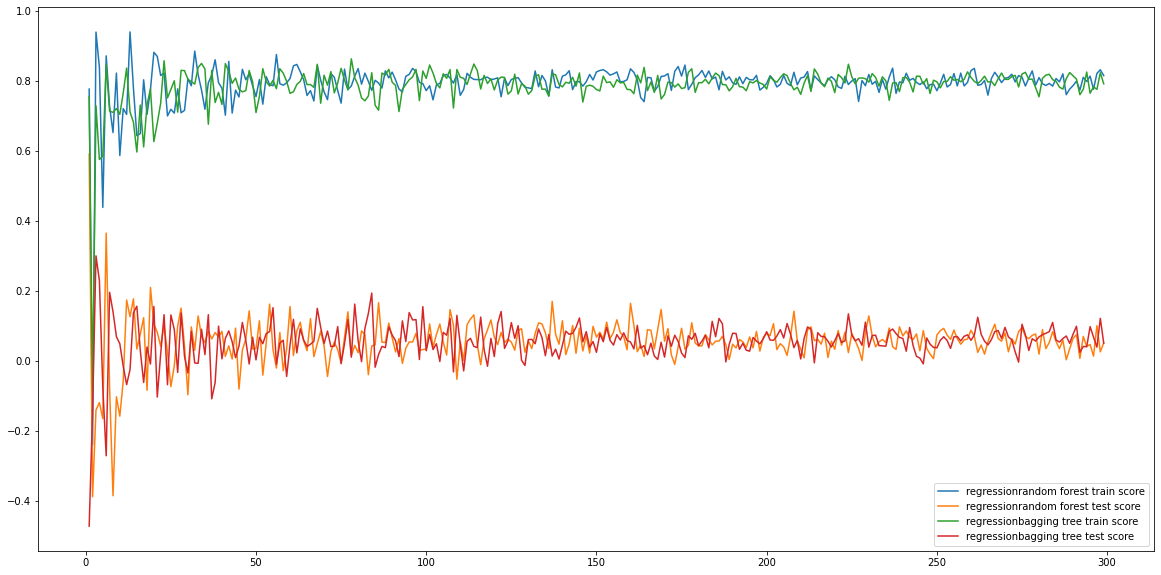

In [7]:
N = 15
D = 100
X = (np.random.random((N, D)) - 0.5)*10
Y = X.sum(axis=1)**2 + 0.5*np.random.randn(N)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

compare_models(X_train, X_test, Y_train, Y_test, num_of_trees=300, prediction_type='regression')

## Compare models on housing data

num_trees: 0
num_trees: 50
num_trees: 100
num_trees: 150
num_trees: 200
num_trees: 250


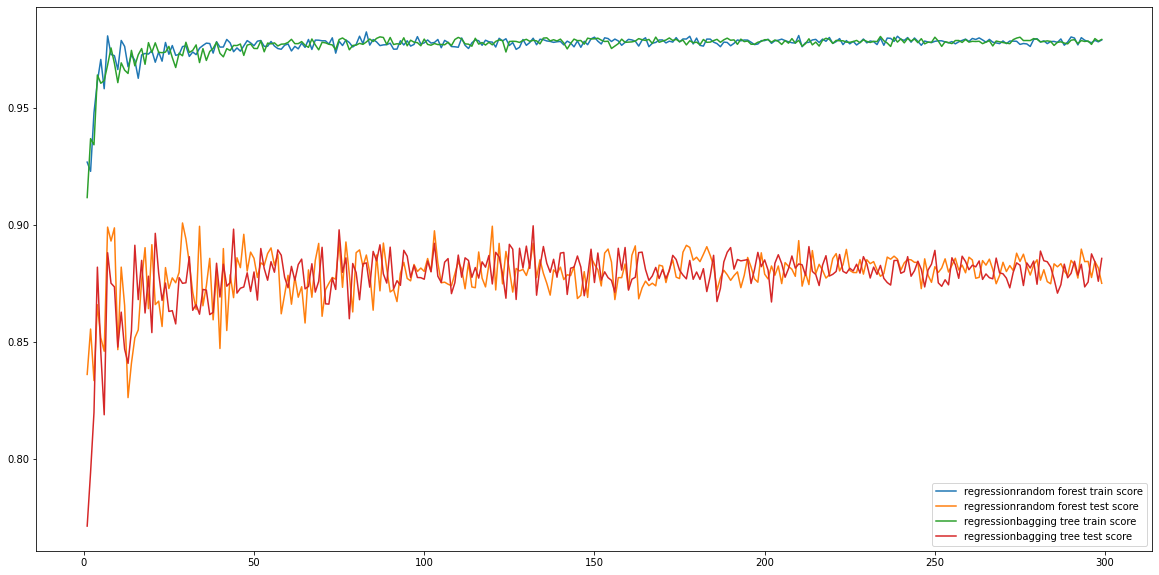

In [8]:
X_train, X_test, Y_train, Y_test = get_housing_data(test_size=0.2)

compare_models(X_train, X_test, Y_train, Y_test, num_of_trees=300, prediction_type='regression')

## Compare models on mashroom data

dimensionality: 139
num_trees: 0
num_trees: 50
num_trees: 100
num_trees: 150
num_trees: 200
num_trees: 250


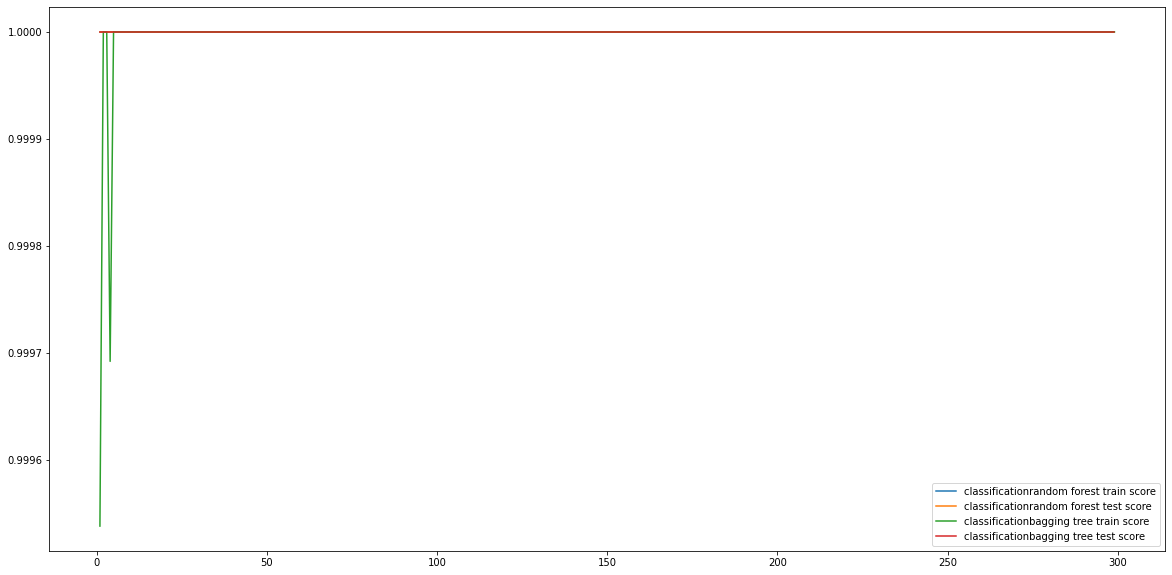

In [9]:
X_train, X_test, Y_train, Y_test = get_mushroom_data(test_size=0.2)

compare_models(X_train, X_test, Y_train, Y_test, num_of_trees=300, prediction_type='classification')